# ウェルネス空調精度検証\_4F 東

## Import libraries


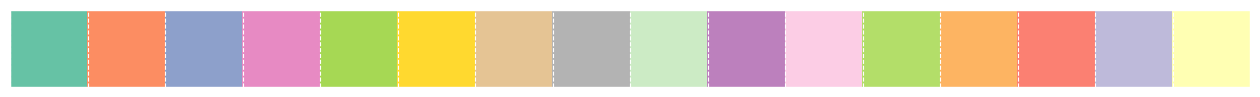

In [1]:
import os
import optuna
import math
import jpholiday
import copy
from datetime import datetime, timedelta
from typing import Union, Literal
import plotly.express as px
import plotly.graph_objects as go
from prettytable import PrettyTable
from pylab import rcParams
from matplotlib import font_manager
import warnings
import seaborn.objects as so
import seaborn as sns
import random
from IPython.display import display, HTML
from pmdarima import arima
from pmdarima import utils
import pmdarima as pm
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import matplotlib.patheffects as patheffects
warnings.filterwarnings('ignore', category=FutureWarning, module='xgboost')
# Filter out specific UserWarnings related to set_ticklabels
warnings.filterwarnings('ignore', category=UserWarning, module='plot_utils',
                        message='.*set_ticklabels.*should only be used with a fixed number of ticks.*')
# from logic import predict_cop,svr_predict,train_RA_8,train_TR_1,train_TR_2,train_TR_3
# graph setting
%matplotlib inline
sns.set_style("darkgrid", {'grid.linestyle': '--'})
sns.set_context("paper", 1.5, {"lines.linewidth": 1.5})
sns.set_palette("Set2")
current_palette = list(sns.color_palette(
    "Set2", n_colors=8) + sns.color_palette("Set3_r", n_colors=8))
sns.set_palette(current_palette)
sns.palplot(current_palette)

# 凡例の色を黒に設定
sns.set(rc={"legend.facecolor": "white",
            "legend.edgecolor": "#c7c5c7",
            "legend.labelcolor": "black"})

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic',
                               'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'Noto Sans CJK JP']
rcParams['axes.axisbelow'] = True

display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# set current working directory dynamically
os.chdir("../..")
print(os.getcwd())
from prediction_module.utilities.score_utils import *

from prediction_module.utilities.data_preprocess import *
from prediction_module.utilities.models import XGBoostModel
from prediction_module.utilities.plot_utils import *
from data_module.config.utils import (
    get_path_from_config,
    get_path_from_config_for_outside_base_folder,
)

/Users/hussain/Menteru-Github/takenaka-wellness-project/takenaka_wellness


## データセットファイルを取得


### 初期設定


In [3]:
CASE_NAME = "v.06.1.1"  # メインケース
building_name = "4F東"
floor = 4
direction = "東"
display(building_name[0], building_name[2])
a = "4F東"
display(a[0], a[2])

'4'

'東'

'4'

'東'

In [4]:
data_train = pd.read_csv(
    get_path_from_config_for_outside_base_folder("train_data_path"),
    encoding="cp932",
)  # 前処理後のデータ
data_predict = pd.read_csv(
    get_path_from_config_for_outside_base_folder("train_data_path"),
    encoding="cp932",
)  # 前処理後のデータ
dict_column_name = pd.read_excel(
    get_path_from_config("dict_column_name_path"),
    sheet_name=None,
)
dict_column_name_experiment = pd.read_excel(
    get_path_from_config("dict_column_name_experiment_path"),
    sheet_name=None,
    index_col="除くカラム",
)
master_data = pd.read_excel(
    get_path_from_config("master_data_path"),
    sheet_name=None,
)
result_df_test = pd.read_csv(
    get_path_from_config("output_folder_path") + "/result_df_4F東_test.csv",
    encoding="cp932",
)

In [5]:
# object型となっているdatetimeとdateをdatetime型に変更
data_train["datetime"] = pd.to_datetime(data_train["datetime"])
data_train["date"] = pd.to_datetime(data_train["date"])
data_predict["datetime"] = pd.to_datetime(data_predict["datetime"])
data_predict["date"] = pd.to_datetime(data_predict["date"])

In [6]:
display(data_predict.columns)

Index(['空調電力予測_kWh', '空調負荷予測_kWh', '外気温度予測値_℃', '外気湿度予測値_RH',
       '室内機消費電力量_kWh_4F_西', '室内機消費電力量_kWh_4F_東', '室内機消費電力量_kWh_5F_西',
       '室内機消費電力量_kWh_5F_東', '室外機消費電力量_kWh_4F_西', '室外機消費電力量_kWh_4F_東',
       '室外機消費電力量_kWh_5F_西', '室外機消費電力量_kWh_5F_東', 'datetime', 'date',
       'fiscal_year', 'month', 'hour', 'is_holiday', '室内相対湿度_RH_4F',
       '室内相対湿度_RH_5F', '室内温度_C_4F執務室_西', '室内温度_C_4F執務室_東', '室内温度_C_5F執務室_西',
       '室内温度_C_5F執務室_東', '設定温度_C_4F執務室_西', '設定温度_C_4F執務室_東', '設定温度_C_5F執務室_西',
       '設定温度_C_5F執務室_東', '湿球温度_C', 'System_ON_OFF_4F_西', 'System_ON_OFF_4F_東',
       'System_ON_OFF_5F_西', 'System_ON_OFF_5F_東', '温度差(外気-室内)_C_4F_西',
       '温度差(外気-室内)_C_4F_東', '温度差(外気-室内)_C_5F_西', '温度差(外気-室内)_C_5F_東',
       '温度差(室内-設定)_C_4F_西', '温度差(室内-設定)_C_4F_東', '温度差(室内-設定)_C_5F_西',
       '温度差(室内-設定)_C_5F_東', '温度差(外気-設定)_C_4F_西', '温度差(外気-設定)_C_4F_東',
       '温度差(外気-設定)_C_5F_西', '温度差(外気-設定)_C_5F_東', 'Operation_Mode_4F_西',
       'Operation_Mode_4F_東', 'Operation_Mode_5F_西', 'Operation_Mode_5F

In [7]:
# predict用データの変更
for k in range(len(data_predict)):
    if data_predict.loc[k, "hour"] <= 4 or data_predict.loc[k, "hour"] >= 22:
        data_predict.at[k, "System_ON_OFF_4F_西"] = 0
        data_predict.at[k, "System_ON_OFF_4F_東"] = 0
        data_predict.at[k, "System_ON_OFF_5F_西"] = 0
        data_predict.at[k, "System_ON_OFF_5F_東"] = 0

In [8]:
a = data_predict[data_predict["hour"] <= 4]
b = data_predict[data_predict["hour"] >= 22]

In [9]:
display(a.loc[:, "System_ON_OFF_4F_西":].describe())
display(b.loc[:, "System_ON_OFF_4F_西":].describe())

,System_ON_OFF_4F_西,System_ON_OFF_4F_東,System_ON_OFF_5F_西,System_ON_OFF_5F_東,温度差(外気-室内)_C_4F_西,温度差(外気-室内)_C_4F_東,温度差(外気-室内)_C_5F_西,温度差(外気-室内)_C_5F_東,温度差(室内-設定)_C_4F_西,温度差(室内-設定)_C_4F_東,温度差(室内-設定)_C_5F_西,温度差(室内-設定)_C_5F_東,温度差(外気-設定)_C_4F_西,温度差(外気-設定)_C_4F_東,温度差(外気-設定)_C_5F_西,温度差(外気-設定)_C_5F_東,Operation_Mode_4F_西,Operation_Mode_4F_東,Operation_Mode_5F_西,Operation_Mode_5F_東
count,4757.0,4757.0,4757.0,4757.0,4757.000000,4757.000000,4757.000000,4757.000000,4757.000000,4757.000000,4757.000000,4757.000000,4757.000000,4757.000000,4757.000000,4757.000000,4757.000000,4757.000000,4757.000000,4757.000000
mean,0.0,0.0,0.0,0.0,-9.836656,-9.766324,-10.154288,-10.026190,-0.204644,-0.233470,0.263473,0.140380,-10.041300,-9.999794,-9.890815,-9.885810,0.459323,0.459323,0.459323,0.459323
std,0.0,0.0,0.0,0.0,5.671389,5.585833,5.775174,5.665105,2.389004,2.404979,2.443021,2.443364,6.479494,6.482373,6.654554,6.554018,0.498395,0.498395,0.498395,0.498395
min,0.0,0.0,0.0,0.0,-27.833125,-27.721250,-27.988750,-27.801875,-10.775625,-10.660625,-10.963125,-10.941250,-26.875000,-25.625000,-25.000000,-25.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.0,0.0,-14.600000,-14.441875,-14.888125,-14.737500,-1.770625,-1.908125,-1.277500,-1.458125,-15.675000,-15.650000,-15.650000,-15.600000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.0,0.0,0.0,-10.003125,-9.961875,-10.284375,-10.185000,0.014375,-0.038750,0.414375,0.311875,-10.150000,-10.150000,-9.950000,-10.050000,0.000000,0.000000,0.000000,0.000000
75%,0.0,0.0,0.0,0.0,-4.535625,-4.513750,-4.875000,-4.788750,1.308750,1.341250,1.787500,1.605000,-4.000000,-4.000000,-3.800000,-3.850000,1.000000,1.000000,1.000000,1.000000
max,0.0,0.0,0.0,0.0,1.621875,1.115625,2.366250,2.325625,7.855000,8.576875,9.570000,9.630625,2.345000,2.334375,2.300000,2.300000,1.000000,1.000000,1.000000,1.000000


,System_ON_OFF_4F_西,System_ON_OFF_4F_東,System_ON_OFF_5F_西,System_ON_OFF_5F_東,温度差(外気-室内)_C_4F_西,温度差(外気-室内)_C_4F_東,温度差(外気-室内)_C_5F_西,温度差(外気-室内)_C_5F_東,温度差(室内-設定)_C_4F_西,温度差(室内-設定)_C_4F_東,温度差(室内-設定)_C_5F_西,温度差(室内-設定)_C_5F_東,温度差(外気-設定)_C_4F_西,温度差(外気-設定)_C_4F_東,温度差(外気-設定)_C_5F_西,温度差(外気-設定)_C_5F_東,Operation_Mode_4F_西,Operation_Mode_4F_東,Operation_Mode_5F_西,Operation_Mode_5F_東
count,1900.0,1900.0,1900.0,1900.0,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000
mean,0.0,0.0,0.0,0.0,-9.080637,-9.051727,-9.423891,-9.339329,0.154291,0.166758,0.630588,0.550516,-8.926346,-8.884970,-8.793303,-8.788813,0.462105,0.462105,0.462105,0.462105
std,0.0,0.0,0.0,0.0,5.755726,5.699243,5.908463,5.790908,2.370370,2.376285,2.421897,2.425692,6.347011,6.352819,6.535804,6.433341,0.498693,0.498693,0.498693,0.498693
min,0.0,0.0,0.0,0.0,-21.614375,-21.251875,-22.300000,-21.976250,-7.274375,-7.037500,-7.376250,-7.433750,-23.950000,-23.950000,-23.950000,-23.950000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.0,0.0,-13.851094,-13.716094,-14.161094,-14.058437,-1.356719,-1.478437,-0.835781,-0.986094,-14.281250,-14.273750,-14.350000,-14.300000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.0,0.0,0.0,-9.089375,-9.088750,-9.557500,-9.474063,0.301250,0.347187,0.650312,0.651250,-8.900000,-8.900000,-8.750000,-8.800000,0.000000,0.000000,0.000000,0.000000
75%,0.0,0.0,0.0,0.0,-3.802656,-3.840156,-4.201250,-4.184375,1.569844,1.675000,2.194375,2.000313,-3.200000,-3.200000,-2.987500,-3.000000,1.000000,1.000000,1.000000,1.000000
max,0.0,0.0,0.0,0.0,1.570000,1.366875,3.314375,3.058750,8.192500,8.926875,10.093750,10.141875,3.100000,3.200000,3.325000,3.100000,1.000000,1.000000,1.000000,1.000000


In [10]:
df = data_predict[
    (data_predict["date"] >= "2023-05-01") & (data_predict["date"] <= "2023-07-31")
]
df = df.iloc[-24:, :]  # 最新24時間分のデータを取得
df = df.reset_index(drop=True)

In [11]:
display(df["date"][0].date().month)

7

In [12]:
result_df_test.head()

,Unnamed: 0,予測,正解,時間,ON/OFF,外気温度予測値_℃
0,0,0.000000,1.0,2021-04-01 04:00:00,0,9.75
1,1,0.000000,0.0,2021-04-01 07:00:00,0,10.35
2,2,2.757294,1.0,2021-04-01 08:00:00,1,12.10
3,3,0.000000,0.0,2021-04-01 12:00:00,0,19.60
4,4,4.408327,1.0,2021-04-01 14:00:00,1,20.60


In [13]:
# 日付データを datetime 型に変換
df["datetime"] = pd.to_datetime(result_df_test["時間"])

# 2022年4月～2023年3月のデータに絞る
# df_filtered = df[(df["datetime"] >= "2022-04-01") & (df["datetime"] < "2023-04-01")]
df_filtered = result_df_test.copy()

In [14]:
def plot_scatter_1(
    ax,
    data: pd.DataFrame,
    x: str,
    y: str,
    xlabel: str = "",
    ylabel: str = "",
    xticks: Union[list, None] = None,
    alpha: float = 1,
    title: Union[str, None] = None,
    color: str = None,
):
    """散布図を作成。"""
    #     sns.scatterplot(data=data, x=x, y=y, alpha=alpha, ax=ax, color=color)
    sns.regplot(
        data=data,
        x=x,
        y=y,
        ax=ax,
        scatter_kws=dict(color=color, facecolor="none", alpha=0.5, s=8),
        line_kws=dict(color="blue", linewidth=2),
    )
    ax.plot(
        np.arange(np.max(data[x])),
        np.arange(np.max((data[x]))),
        linewidth=2,
        color="grey",
        alpha=1,
    )
    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)
    max_ = data[[x, y]].values.flatten().max() * 1.1
    min_ = data[[x, y]].values.flatten().min() * 1.1
    # ax.set_xlim([min_,max_]);ax.set_ylim([min_,max_])
    ax.set_xticks(xticks)
    ax.set_yticks(xticks)
    ax.set_xlim([xticks[0], xticks[-1]])
    ax.set_ylim([xticks[0], xticks[-1]])
    ax.set_aspect(1, adjustable="box")
    ax.set_title(title)


def plot_scatters_train_valid_1(
    score_evaluator_train, score_evaluator_val, xticks, CASE_NAME, feature_name
):
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(1, 2, 1)
    # ax2 = fig.add_subplot(1, 2, 2)
    plot_scatter_1(
        ax1,
        score_evaluator_val,
        x="true",
        y="pred",
        xlabel="実績値",
        ylabel="予測値",
        xticks=xticks,
        alpha=0.5,
        title=f"{feature_name} val({CASE_NAME})",
        color="tab:blue",
    )

    fig.tight_layout()

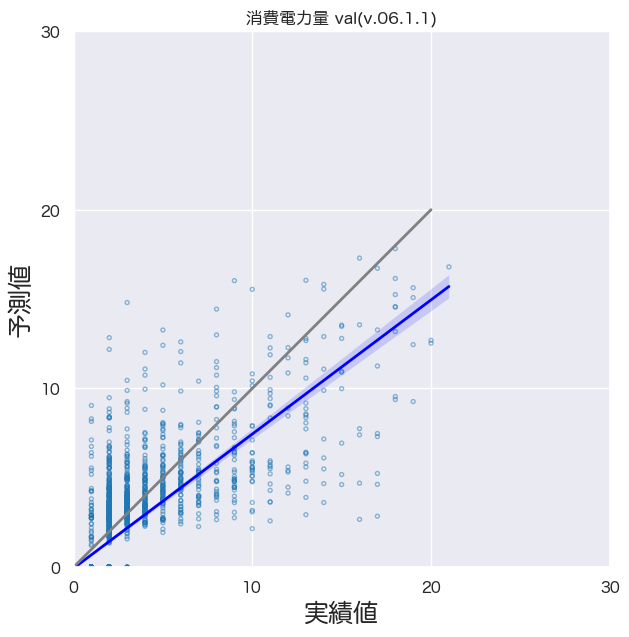

In [ ]:
# `正解` (実測値) と `予測` (予測値) を数値型に変換
df_filtered["true"] = pd.to_numeric(df_filtered["正解"])
df_filtered["pred"] = pd.to_numeric(df_filtered["予測"])

# 欠損値を削除
df_filtered = df_filtered.dropna(subset=["true", "pred"])

ticks = np.arange(0, 31, 10)


class ScoreEvaluator_2:
    def __init__(self, df):
        self.df = df


score_evaluator_train = ScoreEvaluator_2(df_filtered)
score_evaluator_val = ScoreEvaluator_2(df_filtered)
feature_name = "消費電力量"
plot_scatters_train_valid_1(df_filtered, df_filtered, ticks, CASE_NAME, feature_name)

In [16]:
df_filtered.head()

,Unnamed: 0,予測,正解,時間,ON/OFF,外気温度予測値_℃,true,pred
0,0,0.000000,1.0,2021-04-01 04:00:00,0,9.75,1.0,0.000000
1,1,0.000000,0.0,2021-04-01 07:00:00,0,10.35,0.0,0.000000
2,2,2.757294,1.0,2021-04-01 08:00:00,1,12.10,1.0,2.757294
3,3,0.000000,0.0,2021-04-01 12:00:00,0,19.60,0.0,0.000000
4,4,4.408327,1.0,2021-04-01 14:00:00,1,20.60,1.0,4.408327


## Plot Results (グラフを作成)


In [17]:
display(df_filtered)

,Unnamed: 0,予測,正解,時間,ON/OFF,外気温度予測値_℃,true,pred
0,0,0.000000,1.0,2021-04-01 04:00:00,0,9.75,1.0,0.000000
1,1,0.000000,0.0,2021-04-01 07:00:00,0,10.35,0.0,0.000000
2,2,2.757294,1.0,2021-04-01 08:00:00,1,12.10,1.0,2.757294
3,3,0.000000,0.0,2021-04-01 12:00:00,0,19.60,0.0,0.000000
4,4,4.408327,1.0,2021-04-01 14:00:00,1,20.60,1.0,4.408327
...,...,...,...,...,...,...,...,...
6835,6835,0.000000,0.0,2024-03-31 14:00:00,0,23.30,0.0,0.000000
6836,6836,0.000000,0.0,2024-03-31 15:00:00,0,22.65,0.0,0.000000
6837,6837,0.000000,0.0,2024-03-31 18:00:00,0,19.00,0.0,0.000000
6838,6838,0.000000,0.0,2024-03-31 20:00:00,0,16.50,0.0,0.000000


In [18]:
# 数値型のカラムのみを選択
numeric_df = df_filtered.select_dtypes(include=[np.number])
numeric_df.drop(columns=["Unnamed: 0", "true", "pred"], inplace=True)
# 相関行列を表示
display(numeric_df.corr())

df_filtered.drop(columns=["Unnamed: 0", "true", "pred"], inplace=True)

,予測,正解,ON/OFF,外気温度予測値_℃
予測,1.000000,0.824752,0.850755,0.110784
正解,0.824752,1.000000,0.713233,0.125267
ON/OFF,0.850755,0.713233,1.000000,0.217186
外気温度予測値_℃,0.110784,0.125267,0.217186,1.000000


In [19]:
# 調べたい系統を検索
# ここのパラメータをいじって精度検証
floor_direction_name = str(floor) + "F" + direction
eval_metric = "rmse"
x = 23  # 何番目の組み合わせ(どのカラムを抜くか)を設定 元：23
column_name = dict_column_name[
    floor_direction_name
]  # 系統別で用いられる説明変数と目的変数のカラム名
# 精度検証のための表を取得
df_column_name = dict_column_name_experiment[floor_direction_name]
used_column_list = []  # 精度検証で選ばれた説明変数に使うカラム名
delete_column = []  # 目的変数用のカラム名と不要なカラム名
# df_column_name.iloc[〇,k]の○に設定(どのカラムを抜くか)を決定
for k in range(len(df_column_name.columns)):
    if df_column_name.iloc[x, k] == 1:
        used_column_list.append(df_column_name.columns.tolist()[k])
    else:
        if df_column_name.iloc[x, k] == 2:
            delete_column.append(df_column_name.columns.tolist()[k])
display(used_column_list)

['外気温度予測値_℃',
 '外気湿度予測値_RH',
 'fiscal_year',
 'month',
 'hour',
 'is_holiday',
 '設定温度_C_4F執務室_東',
 '湿球温度_C',
 'System_ON_OFF_4F_東',
 '温度差(室内-設定)_C_4F_東',
 '温度差(外気-設定)_C_4F_東',
 'Operation_Mode_4F_東',
 'DayType_土',
 'DayType_日',
 'DayType_月',
 'DayType_木',
 'DayType_水',
 'DayType_火',
 'DayType_金']

In [20]:
data_1 = df_filtered.copy()
data_2 = pd.read_csv(
    "/Users/hussain/Menteru-Github/takenaka-wellness-project/00_Data/01_PreProcessData/original/preprocessed_data_for_train.csv",
    encoding="cp932",
)

objective_data = (
    data_2[delete_column[0]] + data_2[delete_column[1]].tolist()
)  # 学習データの目的変数
data_2["総消費電力量"] = objective_data
# データの前処理
start_date = "2023-04-01"
end_date = "2024-04-01"


data_2 = data_2[(data_2["datetime"] >= start_date) & (data_2["datetime"] <= end_date)]
data_2.set_index("datetime", inplace=True)
data_2 = data_2.drop(data_2.columns[0], axis=1)
data_2.index.name = None
display(len(data_2))

data_1["時間"] = pd.to_datetime(data_1["時間"])
data_1.set_index("時間", inplace=True)
# data_1 = data_1.drop(data_1.columns[0], axis=1)
data_1.index.name = None
display(data_1)

# データの結合
data_2.index = pd.to_datetime(data_2.index)
data_1.index = pd.to_datetime(data_1.index)

main_df = pd.concat([data_2, data_1], axis=1)
main_df = main_df.dropna(how="all")

8754

,予測,正解,ON/OFF,外気温度予測値_℃
2021-04-01 04:00:00,0.000000,1.0,0,9.75
2021-04-01 07:00:00,0.000000,0.0,0,10.35
2021-04-01 08:00:00,2.757294,1.0,1,12.10
2021-04-01 12:00:00,0.000000,0.0,0,19.60
2021-04-01 14:00:00,4.408327,1.0,1,20.60
...,...,...,...,...
2024-03-31 14:00:00,0.000000,0.0,0,23.30
2024-03-31 15:00:00,0.000000,0.0,0,22.65
2024-03-31 18:00:00,0.000000,0.0,0,19.00
2024-03-31 20:00:00,0.000000,0.0,0,16.50


In [21]:
# display(main_df)
display(main_df[(main_df["date"] >= start_date)])
display(
    main_df[(main_df["date"] >= start_date)]["予測"].isnull().sum()
    / len(main_df[(main_df["date"] >= start_date)])
)

,空調負荷予測_kWh,外気温度予測値_℃,外気湿度予測値_RH,室内機消費電力量_kWh_4F_西,室内機消費電力量_kWh_4F_東,室内機消費電力量_kWh_5F_西,室内機消費電力量_kWh_5F_東,室外機消費電力量_kWh_4F_西,室外機消費電力量_kWh_4F_東,室外機消費電力量_kWh_5F_西,...,Operation_Mode_4F_西,Operation_Mode_4F_東,Operation_Mode_5F_西,Operation_Mode_5F_東,DayType,総消費電力量,予測,正解,ON/OFF,外気温度予測値_℃
2023-04-01 00:00:00,0.00,9.70,96.80,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,土,1.0,NaN,NaN,NaN,NaN
2023-04-01 01:00:00,0.00,8.95,97.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,土,0.0,NaN,NaN,NaN,NaN
2023-04-01 02:00:00,3.45,8.45,96.80,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,土,0.0,NaN,NaN,NaN,NaN
2023-04-01 03:00:00,0.00,8.10,97.55,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,土,0.0,0.0,0.0,0.0,8.1
2023-04-01 04:00:00,0.00,7.35,99.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,土,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31 19:00:00,15.10,17.55,79.55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,日,0.0,NaN,NaN,NaN,NaN
2024-03-31 20:00:00,0.00,16.50,82.70,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,日,0.0,0.0,0.0,0.0,16.5
2024-03-31 21:00:00,742.80,15.90,81.00,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,日,1.0,NaN,NaN,NaN,NaN
2024-03-31 22:00:00,156.45,15.30,83.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,日,0.0,NaN,NaN,NaN,NaN


0.7018505825908157

In [22]:
display(main_df.columns)

Index(['空調負荷予測_kWh', '外気温度予測値_℃', '外気湿度予測値_RH', '室内機消費電力量_kWh_4F_西',
       '室内機消費電力量_kWh_4F_東', '室内機消費電力量_kWh_5F_西', '室内機消費電力量_kWh_5F_東',
       '室外機消費電力量_kWh_4F_西', '室外機消費電力量_kWh_4F_東', '室外機消費電力量_kWh_5F_西',
       '室外機消費電力量_kWh_5F_東', 'date', 'fiscal_year', 'month', 'hour',
       'is_holiday', '室内相対湿度_RH_4F', '室内相対湿度_RH_5F', '室内温度_C_4F執務室_西',
       '室内温度_C_4F執務室_東', '室内温度_C_5F執務室_西', '室内温度_C_5F執務室_東', '設定温度_C_4F執務室_西',
       '設定温度_C_4F執務室_東', '設定温度_C_5F執務室_西', '設定温度_C_5F執務室_東', '湿球温度_C',
       'System_ON_OFF_4F_西', 'System_ON_OFF_4F_東', 'System_ON_OFF_5F_西',
       'System_ON_OFF_5F_東', '温度差(外気-室内)_C_4F_西', '温度差(外気-室内)_C_4F_東',
       '温度差(外気-室内)_C_5F_西', '温度差(外気-室内)_C_5F_東', '温度差(室内-設定)_C_4F_西',
       '温度差(室内-設定)_C_4F_東', '温度差(室内-設定)_C_5F_西', '温度差(室内-設定)_C_5F_東',
       '温度差(外気-設定)_C_4F_西', '温度差(外気-設定)_C_4F_東', '温度差(外気-設定)_C_5F_西',
       '温度差(外気-設定)_C_5F_東', 'Operation_Mode_4F_西', 'Operation_Mode_4F_東',
       'Operation_Mode_5F_西', 'Operation_Mode_5F_東', 'DayType', '総消費電力量', 

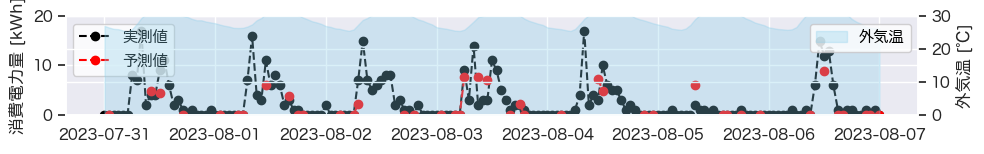

In [23]:
# 時刻別予測結果
# 8月5日から8月15日までのデータをフィルタリング
start_date = "2023-07-31"
end_date = "2023-08-07"
filtered_df = main_df[(main_df.index >= start_date) & (main_df.index <= end_date)]
# display(filtered_df)

# プロット作成
fig, ax1 = plt.subplots(figsize=(10, 1.7))

# 第1軸: 実測値と予測値の線グラフ
ax1.plot(
    filtered_df.index,
    filtered_df.iloc[:, 48],
    color="black",
    marker="o",
    linestyle="--",
    label="実測値",
)
ax1.plot(
    filtered_df.index,
    filtered_df.iloc[:, 49],
    color="red",
    marker="o",
    linestyle="--",
    label="予測値",
)
# ax1.fill_between(filtered_df.index, filtered_df.iloc[:, 48], color='grey', alpha=0.3, label='実測値')
# ax1.set_xlabel('日付')
ax1.set_ylabel("消費電力量 [kWh]")
ax1.grid(True)
ax1.legend(loc="upper left")
ax1.set_ylim(0, 20)

# 第2軸: 外気温の面グラフ
ax2 = ax1.twinx()
ax2.fill_between(
    filtered_df.index,
    filtered_df.iloc[:, 1],
    color="skyblue",
    alpha=0.3,
    label="外気温",
)
ax2.set_ylabel("外気温 [℃]")
ax2.legend(loc="upper right")
ax2.set_ylim(0, 30)

# プロットの表示
plt.tight_layout()
plt.show()
# plt.savefig('scatter_plot_7.png', dpi=300, bbox_inches='tight')

In [24]:
# 予測値の月別平均比較
for month in range(1, 6):
    # 月ごとのデータをフィルタリング
    month_df = main_df[(main_df.index.month == month) & (main_df.index.year == 2023)]

    # "正解"と"予測"の列を選択
    correct_values = month_df.filter(like="正解")
    predicted_values = month_df["予測"]  # "予測"カラムが1つだけと仮定

    # 休日(is_holiday=1)のデータをフィルタリング
    holiday_df = month_df[month_df["is_holiday"] == 1]
    # 平日(is_holiday=0)のデータをフィルタリング
    weekday_df = month_df[month_df["is_holiday"] == 0]

    # 各日ごとのデータをプロット
    def plot_data(df, title, filename):
        correct_values = df.filter(like="正解")
        predicted_values = df["予測"]
        plt.figure(figsize=(7, 2))
        days_in_month = correct_values.index.day.unique()

        # 各日ごとのデータを灰色の線でプロット
        for day in days_in_month:
            daily_data = correct_values[correct_values.index.day == day]
            plt.plot(
                daily_data.index.hour,
                daily_data.mean(axis=1),
                color="gray",
                linewidth=1,
            )

        # "正解"の月平均をオレンジ色でプロット
        correct_hourly_mean = correct_values.groupby(correct_values.index.hour).mean()
        plt.plot(
            correct_hourly_mean.index,
            correct_hourly_mean.mean(axis=1),
            color="orange",
            linewidth=2,
            label="実測値平均 [kWh]",
        )

        # "予測"の月平均を青色でプロット
        predicted_hourly_mean = predicted_values.groupby(
            predicted_values.index.hour
        ).mean()
        plt.plot(
            predicted_hourly_mean.index,
            predicted_hourly_mean,
            color="blue",
            linewidth=2,
            label="予測値平均 [kWh]",
        )

        # グラフのラベルとタイトル
        # plt.xlabel('時刻')
        plt.ylabel("消費電力量 [kWh]")
        plt.xticks(range(0, 23, 4))
        plt.title(title)
        plt.grid(True)
        plt.ylim(0, 20)
        plt.xlim(0, 23)

        # 凡例を追加
        plt.legend(loc="upper right")

        # 図を保存
        # plt.savefig(filename, dpi=300, bbox_inches='tight')

        # プロットの表示
        plt.tight_layout()
        plt.show()

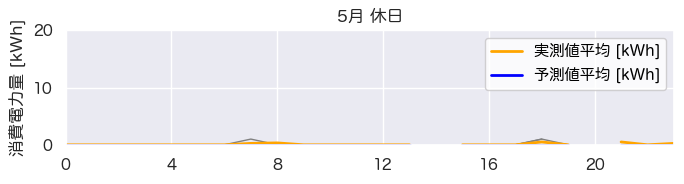

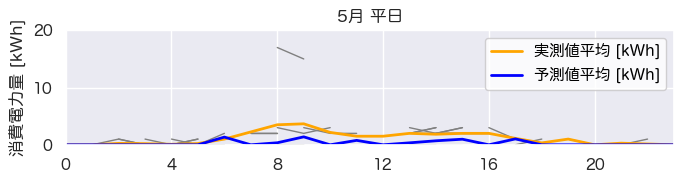

In [25]:
# 休日のデータをプロットし、保存
plot_data(holiday_df, title=f"{month}月 休日", filename=f"{month}月_休日.png")

# 平日のデータをプロットし、保存
plot_data(weekday_df, title=f"{month}月 平日", filename=f"{month}月_平日.png")

In [26]:
# # holiday_df と weekday_df のデータを保存

holiday_df.to_csv(
    f"{month}月_休日_{floor}{direction}.csv", index=False, encoding="cp932"
)
weekday_df.to_csv(
    f"{month}月_平日_{floor}{direction}.csv", index=False, encoding="cp932"
)

In [27]:
graph_params = {
    1: dict(date="2023年5月", specific_season_name="May_week_1"),
    2: dict(date="2023年8月", specific_season_name="Aug_week_1"),
    3: dict(date="2023年11月", specific_season_name="Nov_week_1"),
    4: dict(date="2024年2月", specific_season_name="Feb_week_1"),
}

In [28]:
import matplotlib.patheffects as patheffects

In [29]:
def plot_mae_mape_by_month(df, feature_name, y_limits):
    fig, ax = plt.subplots(figsize=(16, 4))
    xticks = range(1, 13)

    # Plot MAE
    plot1 = ax.plot(
        df["month"],
        df["mean_absolute_error"],
        marker="o",
        color="tab:blue",
        linestyle="--",
        label="MAE",
    )

    # Create a second y-axis for MAPE
    ax2 = ax.twinx()
    plot2 = ax2.plot(
        df["month"],
        df["mean_absolute_percentage_error"],
        marker="s",
        color="tab:orange",
        linestyle="--",
        label="MAPE",
    )

    # Format and settings
    ax.set_xticks(xticks)
    ax.set_axisbelow(True)
    ax2.set_axisbelow(True)
    ax2.grid(False)
    ax.set_title(f"{feature_name} 評価期間: 2023-04-01 ～2024-03-31 ")

    # Combine legends from both plots
    legends = plot1 + plot2
    labels = [l.get_label() for l in legends]
    ax.legend(legends, labels, loc=0)

    # Set y-axis limits
    ax.set_ylim(y_limits[0])
    ax2.set_ylim(y_limits[1])

    ax.set_xlabel("Month")
    ax.set_ylabel("MAE")
    ax2.set_ylabel("MAPE", labelpad=20, rotation=270)

    plt.show()


def plot_mae_rmse_by_month(df, feature_name, y_limits):
    fig, ax = plt.subplots(figsize=(16, 4))
    xticks = range(1, 13)

    a = [float("{:.2g}".format(df["mean_absolute_error"][i])) for i in range(len(df))]
    df["MAE"] = a
    a = [
        float("{:.4g}".format(df["root_mean_squared_error"][i] * 100))
        for i in range(len(df))
    ]
    df["RMSE"] = a

    # Plot MAE
    plot1 = ax.plot(
        df["month"],
        df["MAE"],
        marker="o",
        color="tab:blue",
        linestyle="--",
        label="MAE",
    )
    # マーカーに件数表示
    for idx, val in enumerate(df["MAE"].tolist()):  # df["mean_absolute_error"].tolist()
        ax.text(
            df["month"].tolist()[idx],
            df["MAE"].tolist()[idx] - 0.15,
            f"{val:,}",
            ha="center",
            va="bottom",
            path_effects=[
                patheffects.withStroke(
                    linewidth=3, foreground="white", capstyle="round"
                )
            ],
        )

    # Create a second y-axis for RMSE
    ax2 = ax.twinx()
    plot2 = ax2.plot(
        df["month"],
        df["RMSE"],
        marker="s",
        color="tab:orange",
        linestyle="--",
        label="RMSE",
    )

    # マーカーに件数表示
    for idx, val in enumerate(
        df["RMSE"].tolist()
    ):  # df["mean_absolute_error"].tolist()
        ax2.text(
            df["month"].tolist()[idx],
            df["RMSE"].tolist()[idx] + 5,
            f"{val:,}",
            ha="center",
            va="bottom",
            path_effects=[
                patheffects.withStroke(
                    linewidth=3, foreground="white", capstyle="round"
                )
            ],
        )

    # Format and settings
    ax.set_xticks(xticks)
    ax.set_axisbelow(True)
    ax2.set_axisbelow(True)
    ax2.grid(False)
    # ax.set_title(f"{feature_name} ")#評価期間: 2023-04-01 ～2024-03-31

    # Combine legends from both plots
    legends = plot1 + plot2
    labels = [l.get_label() for l in legends]
    ax.legend(legends, labels, loc=0)

    # Set y-axis limits
    ax.set_ylim(y_limits[0])
    ax2.set_ylim(y_limits[1])

    ax.set_xlabel("Month")
    ax.set_ylabel("MAE[kWh]")
    ax2.set_ylabel("RMSE[%]", labelpad=20, rotation=270)

    plt.show()

In [30]:
df_filtered.head()

,予測,正解,時間,ON/OFF,外気温度予測値_℃
0,0.000000,1.0,2021-04-01 04:00:00,0,9.75
1,0.000000,0.0,2021-04-01 07:00:00,0,10.35
2,2.757294,1.0,2021-04-01 08:00:00,1,12.10
3,0.000000,0.0,2021-04-01 12:00:00,0,19.60
4,4.408327,1.0,2021-04-01 14:00:00,1,20.60


In [31]:
# add datetime column
df_filtered["datetime"] = pd.to_datetime(df_filtered["時間"])

In [ ]:
# based on datetime column extract and add month column
# example of
df_filtered["month"] = df_filtered["datetime"].dt.month


import pandas as pd


def get_scores_by_month_2(df):
    # Ensure 'month' column exists
    if "month" not in df.columns:
        raise KeyError("'month' column is missing in the input DataFrame")

    # Create an empty list to store results
    results = []

    # Iterate over months 1-12
    for month in range(1, 13):
        # Filter data for the specific month
        filtered_df = df[df["month"] == month]

        # Skip if no data for the month
        if filtered_df.empty:
            continue

        # Compute metrics (example, replace with actual calculations)
        mean_absolute_error = filtered_df["予測"].sub(filtered_df["正解"]).abs().mean()
        mean_absolute_percentage_error = (
            filtered_df["予測"].sub(filtered_df["正解"]).abs()
            / filtered_df["正解"].replace(0, 1)
        ).mean() * 100
        root_mean_squared_error = (
            filtered_df["予測"].sub(filtered_df["正解"]) ** 2
        ).mean() ** 0.5

        # Store results in a dictionary
        results.append(
            {
                "month": month,
                "mean_absolute_error": mean_absolute_error,
                "mean_absolute_percentage_error": mean_absolute_percentage_error,
                "root_mean_squared_error": root_mean_squared_error,
            }
        )

    # Convert the list of dictionaries into a DataFrame
    df_scores_month = pd.DataFrame(results)

    return df_scores_month


# Run the function
df_scores_month = get_scores_by_month_2(df_filtered)

# Display the results
display(df_scores_month)

,month,mean_absolute_error,mean_absolute_percentage_error,root_mean_squared_error
0,1,0.669028,38.015865,1.594018
1,2,0.676877,43.762815,1.425937
2,3,0.553624,39.398386,1.137557
3,4,0.569297,42.376132,0.975583
4,5,0.579295,31.398914,1.276070
5,6,0.614328,38.252405,1.082314
6,7,0.731053,29.996160,1.513229
7,8,0.786816,29.280825,1.716493
8,9,0.656701,31.668010,1.226864
9,10,0.559414,38.783909,0.960957


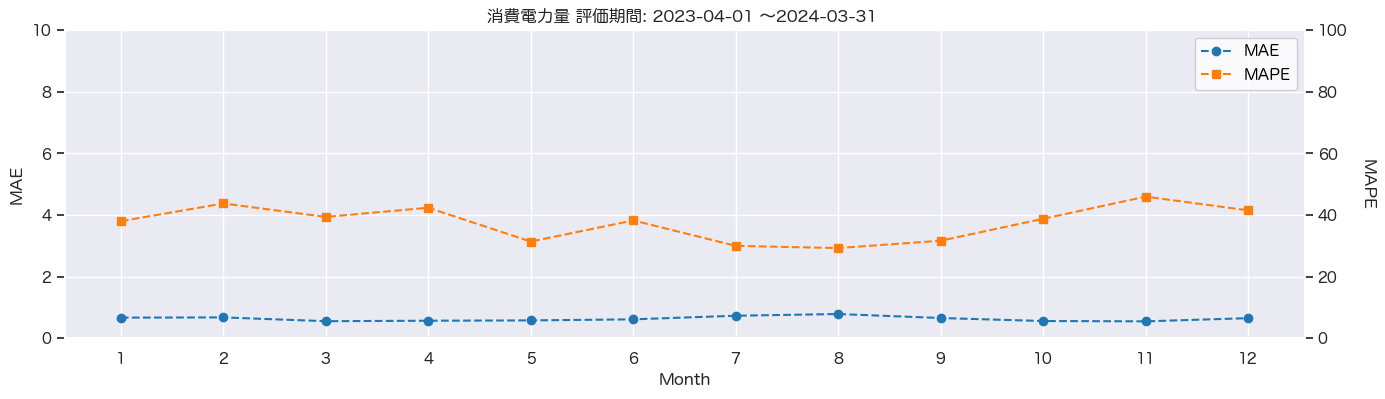

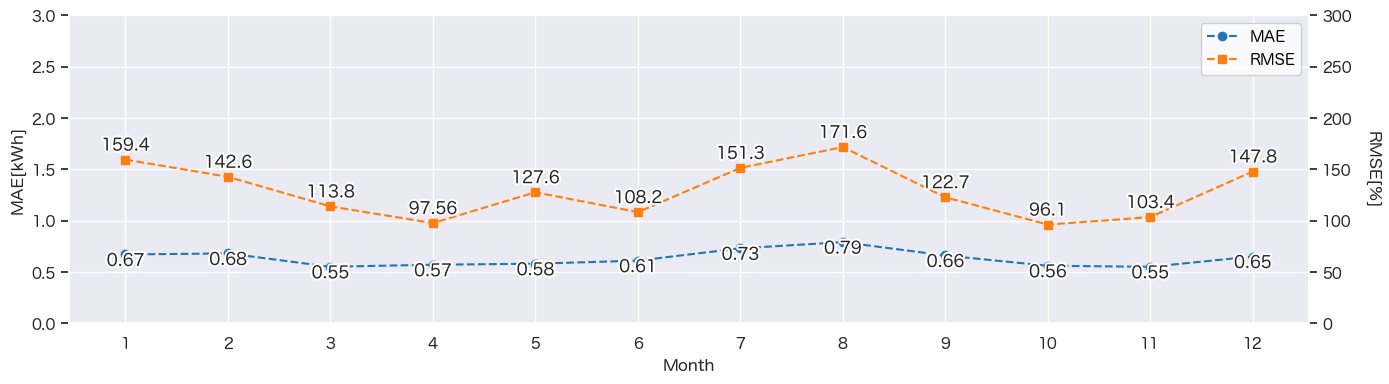

In [33]:
plot_mae_mape_by_month(df_scores_month, feature_name, [[0.0, 10.0], [0.0, 100]])
plot_mae_rmse_by_month(df_scores_month, feature_name, [[0.0, 3.0], [0.0, 300.0]])

In [ ]:
output_filename = f"output_{floor}{direction}.xlsx"

year_month_dict = {2023: [5, 8, 11], 2024: [2, 3]}
with pd.ExcelWriter(output_filename, engine="openpyxl") as writer:
    # 2023年の1月から5月までループ
    for year, months in year_month_dict.items():
        for month in months:
            # 現在の月のデータをフィルタリング
            month_df = main_df[
                (main_df.index.year == year) & (main_df.index.month == month)
            ]
            if month_df.empty:
                continue  # データがなければスキップa

            # Separate weekdays and weekends using the datetime index
            # Monday (0) to Friday (4) are weekdays; Saturday (5) and Sunday (6) are weekends.
            weeek_df = month_df[month_df.index.dayofweek < 5]
            weekend_df = month_df[month_df.index.dayofweek >= 5]

            for subset, subset_name in zip([weeek_df, weekend_df], ["平日", "休日"]):
                if subset.empty:
                    continue  # データがなければスキップ

                # 予測値の時刻ごとの平均値を計算
                predicted_hourly = subset["予測"].groupby(subset.index.hour).mean()

                # 実測値 ("正解" 列) の時刻ごとの平均値を計算
                # 複数の "正解" 列がある場合は、まず各タイムスタンプでの平均を計算し、その後時間単位で平均を計算
                actual_hourly = (
                    subset.filter(like="正解")
                    .mean(axis=1)
                    .groupby(subset.index.hour)
                    .mean()
                )

                # 0〜23時の時間をインデックスとしてDataFrameを作成
                hours = list(range(24))
                df_excel = pd.DataFrame(
                    {
                        "時間": [f"{h}:00" for h in hours],
                        "予測の時刻別平均値": [
                            predicted_hourly.get(h, np.nan) for h in hours
                        ],
                        "実測の時刻別平均値": [
                            actual_hourly.get(h, np.nan) for h in hours
                        ],
                    }
                )
                df_excel.set_index("時間", inplace=True)

                # 各日ごとの実測値（各日の各時刻の値）を追加（NaNも含む）
                unique_days = sorted(subset.index.day.unique())
                for day in unique_days:
                    # 各日のデータをフィルタリング
                    day_df = subset[subset.index.day == day]
                    # 各タイムスタンプでの実測値（"正解" 列の平均）を計算
                    daily_series = day_df.filter(like="正解").mean(axis=1)
                    # 時刻ごとに平均値を計算
                    daily_hourly = daily_series.groupby(day_df.index.hour).mean()
                    # 0〜23時すべての時間に対して値を整える（データがない時間はNaN）
                    daily_hourly = daily_hourly.reindex(hours)
                    # カラム名を「{day}日」として追加
                    df_excel[f"{day}日"] = daily_hourly.values

                # 各月のデータをExcelのシートに書き込む（シート名例："2023-01"）
                sheet_name = f"{year}-{month:02d} {subset_name}"
                df_excel.to_excel(writer, sheet_name=sheet_name)

print(f"Excel file '{output_filename}' has been created.")

Excel file 'output_4東.xlsx' has been created.
